# load data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

items_df = pd.read_csv('data/items.csv')
shops_df = pd.read_csv('data/shops.csv')

icats_df = pd.read_csv('data/item_categories.csv')
train_df = pd.read_csv('data/sales_train.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
smpsb_df = pd.read_csv('data/sample_submission.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
test_df  = pd.read_csv('data/test.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
# Any results you write to the current directory are saved as output.

# narrow categories

In [2]:
l = list(icats_df.item_category_name)
l_cat = l

for ind in range(1,8):
    l_cat[ind] = 'Access'

for ind in range(10,18):
    l_cat[ind] = 'Consoles'

for ind in range(18,25):
    l_cat[ind] = 'Consoles Games'

for ind in range(26,28):
    l_cat[ind] = 'phone games'

for ind in range(28,32):
    l_cat[ind] = 'CD games'

for ind in range(32,37):
    l_cat[ind] = 'Card'

for ind in range(37,43):
    l_cat[ind] = 'Movie'

for ind in range(43,55):
    l_cat[ind] = 'Books'

for ind in range(55,61):
    l_cat[ind] = 'Music'

for ind in range(61,73):
    l_cat[ind] = 'Gifts'

for ind in range(73,79):
    l_cat[ind] = 'Soft'


icats_df['cats'] = l_cat
icats_df.head()

,item_category_name,item_category_id,cats
0,PC - Гарнитуры/Наушники,0,PC - Гарнитуры/Наушники
1,Аксессуары - PS2,1,Access
2,Аксессуары - PS3,2,Access
3,Аксессуары - PS4,3,Access
4,Аксессуары - PSP,4,Access


## Pre-Train

In [3]:
train_df['date'] = pd.to_datetime(train_df.date,format="%d.%m.%Y")
train_df.head()


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [4]:
## Pivot by monht to wide format
p_df = train_df.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_day',aggfunc='sum').fillna(0.0)
p_df.head()

date_block_num    0     1    2    3    4    5    6    7    8    9  ...    24  \
shop_id item_id                                                    ...         
0       30       0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        31       0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        32       6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        33       3.0   3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        35       1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   

date_block_num    25   26   27   28   29   30   31   32   33  
shop_id item_id                                               
0       30       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        33       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        35       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 34 columns]

In [5]:
## Join with categories
train_cleaned_df = p_df.reset_index()
train_cleaned_df['shop_id']= train_cleaned_df.shop_id.astype('str')
train_cleaned_df['item_id']= train_cleaned_df.item_id.astype('str')

item_to_cat_df = items_df.merge(icats_df[['item_category_id','cats']], how="inner", on="item_category_id")[['item_id','cats']]
item_to_cat_df[['item_id']] = item_to_cat_df.item_id.astype('str')

train_cleaned_df = train_cleaned_df.merge(item_to_cat_df, how="inner", on="item_id")

# Encode Categories
from sklearn import preprocessing

number = preprocessing.LabelEncoder()
train_cleaned_df[['cats']] = number.fit_transform(train_cleaned_df.cats)
train_cleaned_df = train_cleaned_df[['shop_id', 'item_id', 'cats'] + list(range(34))]
train_cleaned_df.head()


,shop_id,item_id,cats,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,0,30,7,0.0,31.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,30,7,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,30,7,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,30,7,0.0,4.0,5.0,2.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,30,7,0.0,7.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modelling

In [6]:
import xgboost as xgb
param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}

progress = dict()
xgbtrain = xgb.DMatrix(train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values, 
                       train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values)
watchlist  = [(xgbtrain,'train-rmse')]

bst = xgb.train(param, xgbtrain)
preds = bst.predict(xgb.DMatrix(train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values))
from sklearn.metrics import mean_squared_error 
rmse = np.sqrt(mean_squared_error(preds,train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values))
print(rmse)

1.2689511952065005


In [7]:
train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values
preds

array([0.08432132, 0.08432132, 0.05510584, ..., 0.05483106, 0.12050465,
       0.04214352], dtype=float32)

In [8]:
xgb.plot_importance(bst)

## Apply Model

In [9]:
apply_df = test_df
apply_df['shop_id']= apply_df.shop_id.astype('str')
apply_df['item_id']= apply_df.item_id.astype('str')

apply_df = test_df.merge(train_cleaned_df, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
apply_df.head()

,ID,shop_id,item_id,cats,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


(214200, 38)


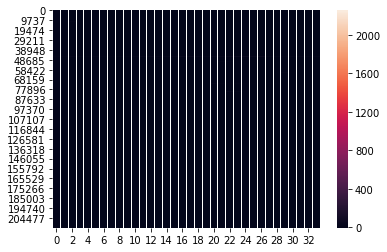

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
print(apply_df.shape)

sns.heatmap(apply_df.loc[:,apply_df.columns[4:]])


(array([359469.,      0., 109854.,      0.,      0.,  45773.,      0.,
         24321.,      0.,  15026.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

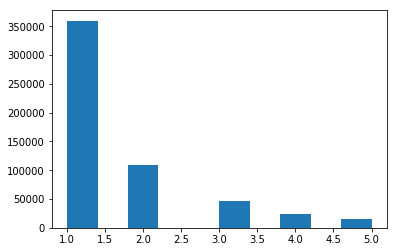

In [24]:
plt.hist(apply_df.loc[:,apply_df.columns[4:]].as_matrix().flatten(), range=(1,5))

In [14]:
# Move to one month front
d = dict(zip(apply_df.columns[4:],list(np.array(list(apply_df.columns[4:])) - 1)))

apply_df  = apply_df.rename(d, axis = 1)

In [15]:
preds = bst.predict(xgb.DMatrix(apply_df.iloc[:, (apply_df.columns != 'ID') & (apply_df.columns != -1)].values))


In [16]:
print(preds[:10])

[0.37082583 0.17790613 0.6018691  0.19598347 0.17790613 0.47903728
 0.6787242  0.08429003 1.0410964  0.17790613]


In [12]:
# Normalize prediction to [0-20]
preds = list(map(lambda x: min(20,max(x,0)), list(preds)))
sub_df = pd.DataFrame({'ID':apply_df.ID,'item_cnt_month': preds })
sub_df.describe()

,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,0.293472
std,61834.358168,0.686291
min,0.000000,0.000000
25%,53549.750000,0.138123
50%,107099.500000,0.177906
75%,160649.250000,0.279623
max,214199.000000,20.000000


In [13]:
sub_df.to_csv('xg_boost4_cats.csv',index=False)

In [14]:
sub_df

,ID,item_cnt_month
0,0,0.370826
1,1,0.177906
2,2,0.601869
3,3,0.195983
4,4,0.177906
5,5,0.479037
6,6,0.678724
7,7,0.084290
8,8,1.041096
9,9,0.177906
